# COCO dataset -- Dowload and preparation

## 1. Download the dataset
### 1.1 Download and extract the annotation files
### 1.2 Selected the images of interest and the corresponding labels

## 2. Image preparation
...

In [1]:

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from imutils import paths
import skimage.io as io
import numpy as np
import cv2
import os

from bodypose.demo.graphics import draw_keypoints, draw_point
from config import KEYPOINT_DICT

## 1. Download the dataset

### 1.1 Download and extract the annotation files

In [2]:
annDir = "./dataset/coco/"
annFileURLs = ["http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
                "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"]

if not os.path.isdir(annDir):
    os.makedirs(annDir)
    
def download_annotations(URL, force_download=False):
    
    download_ann = True
    fileName = URL.split(os.sep)[-1]
    dataType = fileName.split("_")[-1].split(".")[0][-4:]  
    zipPath = os.sep.join([".", fileName])
    dstPath = os.sep.join([annDir, "annotations"])
    
    print(f"[INFO]  Attempting to download {fileName}...")
    
    if os.path.isdir(dstPath):
        files = list(paths.list_files(annDir, contains=dataType))
        if files:
            download_ann = False
            print(f"[INFO] Annotations {dataType} already downloaded in {annDir}.")
    else: 
        os.makedirs(dstPath)
    
    if force_download:
        download_ann = True
        print("[INFO] Forcing download...")
        
    if download_ann:
        if not os.path.exists(zipPath):
            !wget $URL
        !unzip $zipPath 
        !mv  ./annotations/* $dstPath
        !rm -r ./annotations
        !rm $zipPath
    
    print(f"[INFO] Annotations downloaded at {dstPath}.")
        

for url in annFileURLs:
    download_annotations(url)

[INFO]  Attempting to download annotations_trainval2014.zip...
[INFO] Annotations 2014 already downloaded in ./dataset/coco/.
[INFO] Annotations downloaded at ./dataset/coco//annotations.
[INFO]  Attempting to download annotations_trainval2017.zip...
[INFO] Annotations 2017 already downloaded in ./dataset/coco/.
[INFO] Annotations downloaded at ./dataset/coco//annotations.


### 1.2 Selected the images of interest and the corresponding labels

We select only images containing persons. On those pics we apply the following rules: 
- Select  all keyPoints (visible and not visible) 
- Select the most centered person on the basis of the visible keyPoints 
- Check that the selected person is "big" enough inside the image size 
- Save the image and the corresponding keypoint 

In [29]:
dataDir = "./dataset/coco/"

def select_imgs_with_persons(dataType):
    """ 
        Selects all the images containing persons from the coco datasets.
        
        Params
        ------
        datatype: str
            Data source. Options: 'train2014', 'val2014', 'train2017', 'val2017'.
            
        Returns
        -------
        imgs: list(dict)
            List of dict containing the images information.
        coco_kps: pycocotools.coco.COCO
            Object containing all the keypoints information of the selected images.
    """
    annFile = f"{dataDir}/annotations/instances_{dataType}.json"
    coco_anns = COCO(annFile)
    catIds = coco_anns.getCatIds(catNms=['person'])
    imgIds = coco_anns.getImgIds(catIds=catIds)
    print(f"[INFO] Found {len(imgIds)} raw images...")
    
    kptsFile = f"{dataDir}/annotations/person_keypoints_{dataType}.json"
    coco_kps = COCO(kptsFile)
    imgs = coco_anns.loadImgs(imgIds)
    
    return imgs, coco_kps


def get_centre_of_mass(keypoints_list):
    """
        Returns the centers of mass of a given list of keypoints.
        
        Params
        ------
        keypoints_list: np.array
            Array of shape (# of persons, # of joints, 3) containing all the keypoints coordinates.
        
        Returns
        -------
        centers: np.array
            Array of shape (# of persons, 2) with the coordinates of the persons centre of mass.
    """
    centers = []
    
    for skeleton in keypoints_list:
        vis_joints = skeleton[:,-1] == 2
        centers.append(skeleton[vis_joints].mean(axis=0)[:2])
    
    centers = np.array(centers)
    
    return centers


def get_most_centered_keypoints(coco_kps, imgId, img_size):
    """
        Returns the keypoints coordinates of the most centered person.
        
        Params
        ------
        coco_kps: pycocotools.coco.COCO
            Object containing all the keypoints information of the selected images.
        imgId: str
            Image Id.
        img_size: tuple
            Image height and width in pixels.
        
        Returns
        -------
        most_centered: np.array
            Array of shape (# of joints, 3)with the coordinates of the most centered person.
    """
    annIds = coco_kps.getAnnIds(imgIds=imgId, catIds=[1], iscrowd=False)
    anns = coco_kps.loadAnns(annIds)
    keypoints_list = []
    
    for ann in anns:

        keypoints = np.array(ann["keypoints"], dtype=np.float32).reshape(-1, 3)
        keypoints[:,:2] = keypoints[:,:2] / img_size[::-1]
        
        if keypoints[:,:2].sum() == 0:
            continue
        
        keypoints_list.append(keypoints)
    
    if len(keypoints_list)==0:
        return np.empty((17,3), dtype=np.float64), np.empty((0, 2), dtype=np.float64)
        
    keypoints_list = np.array(keypoints_list)
    centers = get_centre_of_mass(keypoints_list)
    
    # get most centered skeleton
    most_centered = np.linalg.norm(centers - (.5, .5), axis=1).argmin() 
    most_centered = keypoints_list[most_centered]
    
    most_centered[:, -1] /=2

    return np.nan_to_num(most_centered), np.nan_to_num(centers)
    

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
[INFO] Found 2693 raw images...
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


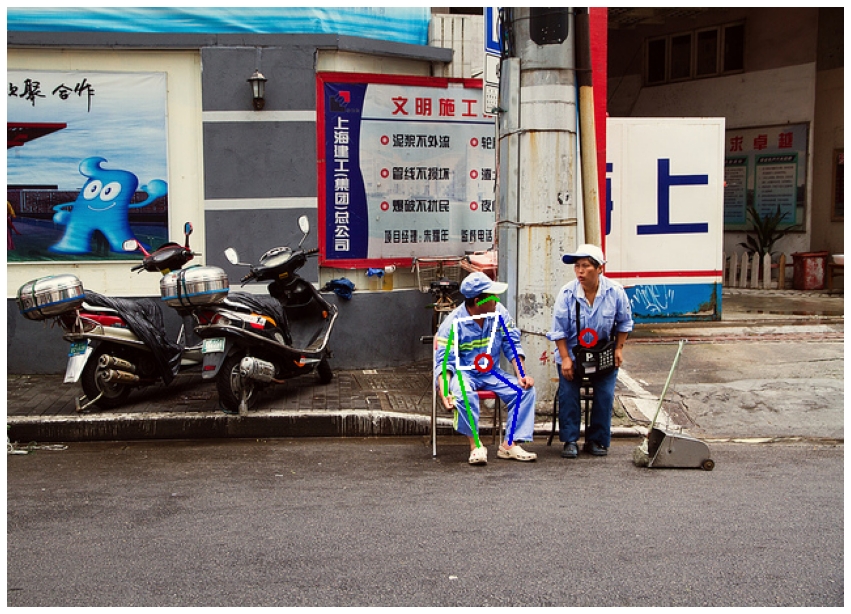

In [4]:
imgs, kps = select_imgs_with_persons("val2017")

i = 6

imgId, img_size = imgs[i]["id"], (imgs[i]["height"], imgs[i]["width"])
img_arr = io.imread(imgs[i]["coco_url"])
c_keypts, centers = get_most_centered_keypoints(kps, imgId, img_size)

with_kpts = draw_keypoints(img_arr, c_keypts, .5, KEYPOINT_DICT)
with_centers = draw_point(with_kpts, centers)

fig = plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(with_kpts)


In [42]:
cv2.imwrite("./prova.png", img_arr[:,:,::-1])

True

In [46]:
print(imgs[10])

{'license': 1, 'file_name': '000000401446.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000401446.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-17 16:37:02', 'flickr_url': 'http://farm9.staticflickr.com/8226/8594006748_3b25699ef0_z.jpg', 'id': 401446}


In [27]:
from calendar import day_abbr


def save_keypoints(coords, txtPath):
    """
        Saves keypoints coordinates and visibility ina txt file.

        Params
        ------
        c_keypts: np.array
            Array of shape  (N_JOINTS, 3) and dtype float
        txtPath: str
            Path to the txt file.
        
        Returns
        -------
        isLabelSaved: bool
            True if the labels has been saved, False otherwise.
    """
    isLabelSaved = True
    
    try:
        with open(txtPath, "w+") as f:
            if coords.shape[-1]==3:
                for coord in coords:
                    x, y, v = coord
                    f.write(f"{x} {y} {v}\n")
            elif coords.shape[-1]==2:
                for coord in coords:
                    x, y= coord
                    f.write(f"{x} {y}\n")
            else:
                isLabelSaved = False

    except Exception as e:
        isLabelSaved = False
        print("[ERROR] Exception occurred in saving keypoints coordinates.")
        print(e)
    
    return isLabelSaved


def download_imgs_and_labels(dataType, dstDir):
    """ 
        Downloads images and labels. Skips the images that have been already dowloaded.

        Params
        ------
        dataType: str
            COCO data subset.
        dstDir: str
            Dataset saving directory

        Returns
        -------
        None
    
    """
    imgs, kps = select_imgs_with_persons(dataType)
    
    subDir = "validation" if "val" in dataType else "train"
    dstDir = os.sep.join([dstDir, subDir])
    if not os.path.isdir(dstDir):
        os.makedirs(dstDir)
    
    for i in range(len(imgs)):
        
        print(f"\r[INFO]  Processing image {i+1}/{len(imgs)}...", end="")

        imgId, img_size = imgs[i]["id"], (imgs[i]["height"], imgs[i]["width"])

        imgPath = os.sep.join([dstDir, f"{dataType}_{imgId}.png"])
        kptsTxtPath = imgPath.replace(".png", "_kpts.txt")
        cntrsTxtPath = imgPath.replace(".png", "_cntrs.txt")

        if os.path.exists(imgPath) and os.path.exists(kptsTxtPath) and os.path.exists(cntrsTxtPath):
            continue

        img_arr = io.imread(imgs[i]["coco_url"])
        c_keypts, c_centers = get_most_centered_keypoints(kps, imgId, img_size)
        
        img_arr = io.imread(imgs[i]["coco_url"])
        if len(img_arr.shape) == 3: 
            img_arr  = img_arr[:, :, ::-1]

        isImgSaved = cv2.imwrite(imgPath, img_arr)
        if not isImgSaved:
            print(f"[ERROR] Could not save image: {imgId}.")
            break
        
        isLabelSaved = save_keypoints(c_keypts, kptsTxtPath)
        if not isLabelSaved:
            print(f"[ERROR] Could not save label: {kptsTxtPath}.")
            break

        isLabelSaved = save_keypoints(c_centers, cntrsTxtPath)
        if not isImgSaved:
            print(f"[ERROR] Could not save label: {cntrsTxtPath}.")
            break

In [30]:

for dataType in ["val2017", "val2014", "train2017", "train2014"]:
    
    print(f"*** {dataType.capitalize()} dataset ***")
    download_imgs_and_labels(dataType, "dataset/coco/")
    print("\n\n")

*** Val2017 dataset ***
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
[INFO] Found 2693 raw images...
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
[INFO]  Processing image 2693/2693...


*** Val2014 dataset ***
loading annotations into memory...
Done (t=6.53s)
creating index...
index created!
[INFO] Found 21634 raw images...
loading annotations into memory...
Done (t=3.18s)
creating index...
index created!
[INFO]  Processing image 1396/21634...